# Import Packages

In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
data_path = "/kaggle/input/de-fungi/de_fungi" 

images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})

In [3]:
data.head()

image label
0   /kaggle/input/de-fungi/de_fungi/H3/H3_5a_17.jpg    H3
1    /kaggle/input/de-fungi/de_fungi/H3/H3_5b_9.jpg    H3
2  /kaggle/input/de-fungi/de_fungi/H3/H3_11a_42.jpg    H3
3   /kaggle/input/de-fungi/de_fungi/H3/H3_3c_16.jpg    H3
4   /kaggle/input/de-fungi/de_fungi/H3/H3_29a_3.jpg    H3

In [4]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (100, 100)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator()  


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 2956 validated image filenames belonging to 5 classes.
Found 369 validated image filenames belonging to 5 classes.
Found 370 validated image filenames belonging to 5 classes.


In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        
        if accuracy:
            print(f"Epoch {epoch + 1}: Training accuracy is {accuracy:.4f}")
        if val_accuracy:
            print(f"Epoch {epoch + 1}: Validation accuracy is {val_accuracy:.4f}")
        
        if (accuracy and accuracy > 0.99) or (val_accuracy and val_accuracy > 0.99):
            print("\nReached 99% accuracy in training or validation, so cancelling training!")
            self.model.stop_training = True

# Pretrained ResNet101 with custom layers

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training ResNet101...
Epoch 1/20


I0000 00:00:1743512516.069875      92 service.cc:145] XLA service 0x7a99e4003cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743512516.069930      92 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1743512556.541106      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_50', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1743512556.612934      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.5933 - loss: 1.0559
Epoch 1: val_loss improved from inf to 0.89260, saving model to resnet101_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 167s 736ms/step - accuracy: 0.5942 - loss: 1.0535 - val_accuracy: 0.6369 - val_loss: 0.8926 - learning_rate: 1.0000e-04
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8064 - loss: 0.5287
Epoch 2: val_loss improved from 0.89260 to 0.62318, saving model to resnet101_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.8066 - loss: 0.5283 - val_accuracy: 0.8049 - val_loss: 0.6232 - learning_rate: 1.0000e-04
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8435 - loss: 0.4147
Epoch 3: val_loss did not improve from 0.62318
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.8436 - loss: 0.4144 - val_accuracy: 0.8401 - val_loss: 0.6919 - learning_rate: 1.0000e-04
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8917 - loss: 0.

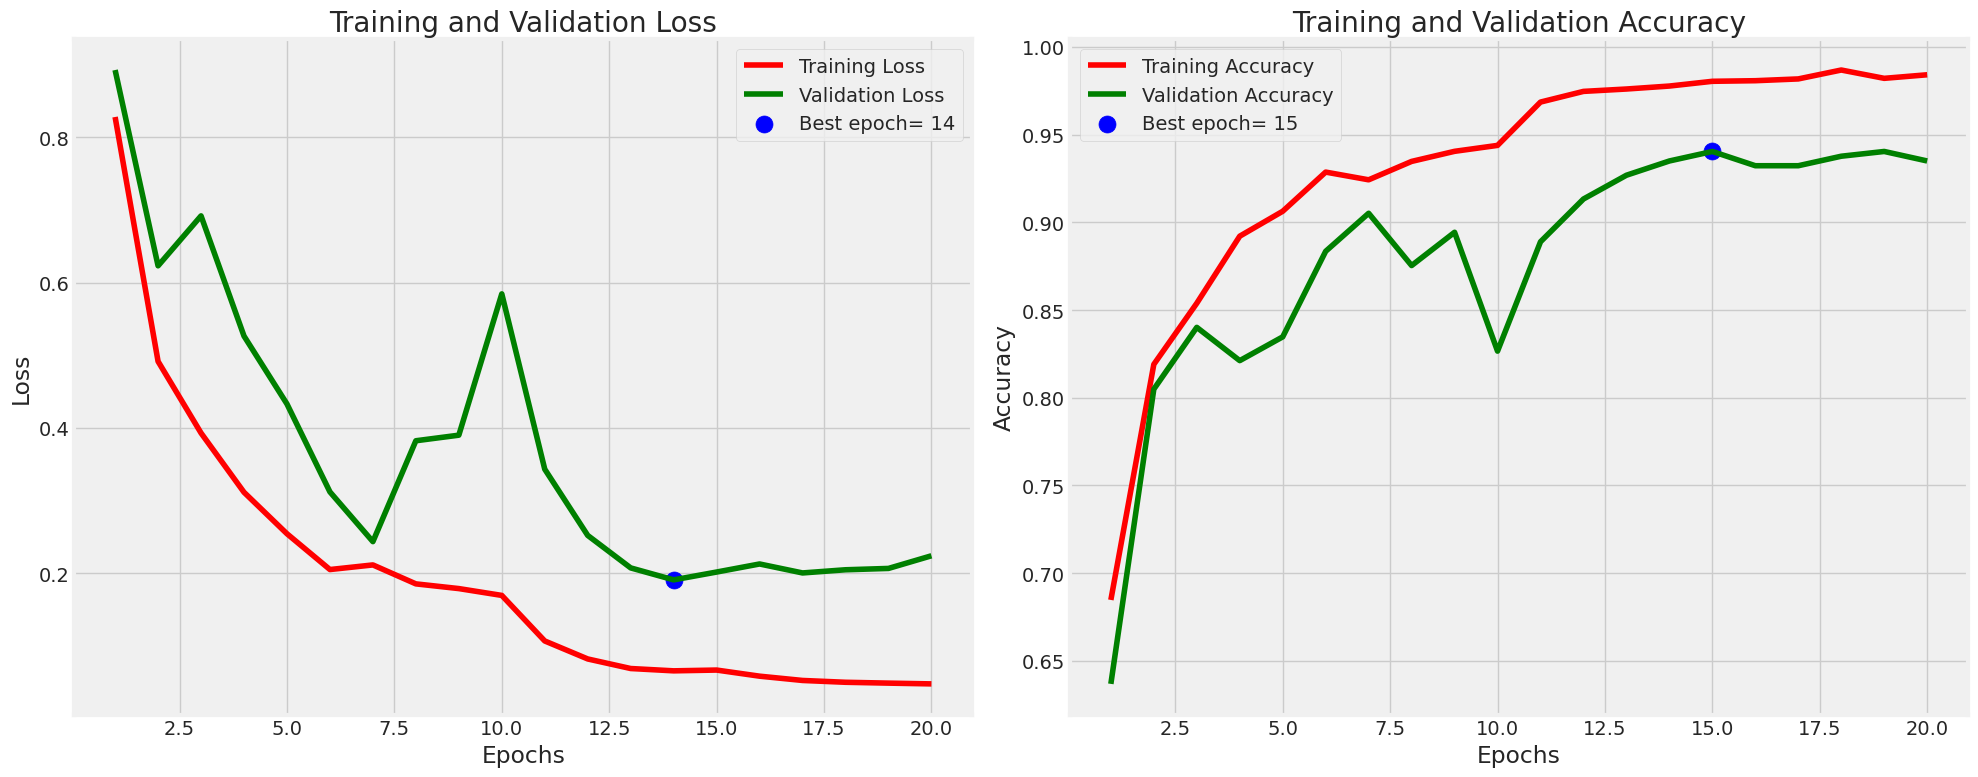

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 0.0082
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9284 - loss: 0.1466
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9032 - loss: 0.3113
Train Loss:  0.007880911231040955
Train Accuracy:  1.0
--------------------
Valid Loss:  0.14299553632736206
Valid Accuracy:  0.9375
--------------------
Test Loss:  0.2998877167701721
Test Accuracy:  0.90625


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

base_model_resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_resnet101_model():
    x = base_model_resnet101.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)

    model_resnet101 = Model(inputs=base_model_resnet101.input, outputs=output)
    model_resnet101.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])
    return model_resnet101

def train_and_evaluate_resnet101(train_gen, valid_gen):
    print("Training ResNet101...")
    
    model_resnet101 = build_resnet101_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    checkpoint = ModelCheckpoint('resnet101_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_resnet101 = model_resnet101.fit(
        train_gen,
        epochs=20,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model_resnet101.evaluate(valid_gen)
    print(f"ResNet101 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_resnet101.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)
    val_true_labels = valid_gen.classes

    print(f"ResNet101 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

    return model_resnet101, history_resnet101  

model_resnet101, history_resnet101 = train_and_evaluate_resnet101(train_gen, valid_gen)

tr_acc = history_resnet101.history['accuracy']
tr_loss = history_resnet101.history['loss']
val_acc = history_resnet101.history['val_accuracy']
val_loss = history_resnet101.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch= {str(index_loss + 1)}'
acc_label = f'Best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_plots.png')
plt.show()

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model_resnet101.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model_resnet101.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model_resnet101.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [8]:
model_resnet101.save('resnet101_final_model.h5')  


# LIME

# H1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

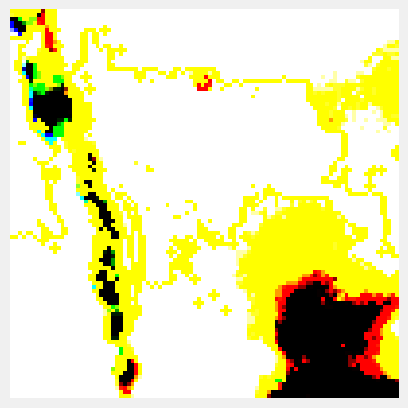

In [10]:
import lime
import lime.lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.segmentation import mark_boundaries
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np

model = load_model('/kaggle/working/resnet101_final_model.h5')

explainer = lime.lime_image.LimeImageExplainer()

img_path = '/kaggle/input/de-fungi/de_fungi/H1/H1_10a_5.jpg'
img = Image.open(img_path).resize((100, 100))
img = np.array(img)

if len(img.shape) == 2:
    img = np.stack((img,)*3, axis=-1)

img = preprocess_input(img)

def predict_fn(images):
    processed_images = np.array([preprocess_input(image) for image in images])
    return model.predict(processed_images)

explanation = explainer.explain_instance(img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.savefig("Cyst.png", dpi=300, bbox_inches='tight')

plt.show()

# H2

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

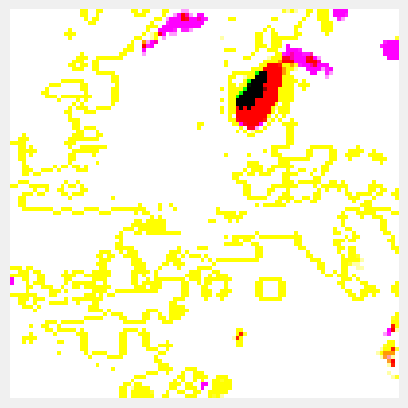

In [11]:
import lime
import lime.lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.segmentation import mark_boundaries
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np

model = load_model('/kaggle/working/resnet101_final_model.h5')

explainer = lime.lime_image.LimeImageExplainer()

img_path = '/kaggle/input/de-fungi/de_fungi/H2/H2_11a_1.jpg'
img = Image.open(img_path).resize((100, 100))
img = np.array(img)

if len(img.shape) == 2:
    img = np.stack((img,)*3, axis=-1)

img = preprocess_input(img)

def predict_fn(images):
    processed_images = np.array([preprocess_input(image) for image in images])
    return model.predict(processed_images)

explanation = explainer.explain_instance(img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.savefig("Cyst.png", dpi=300, bbox_inches='tight')

plt.show()

# H3

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

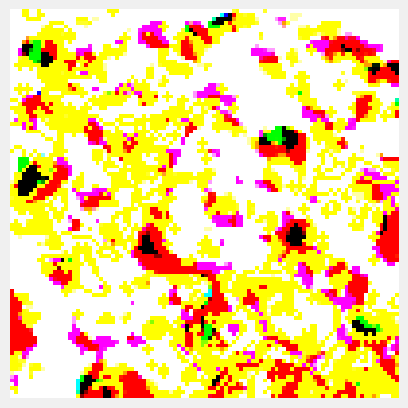

In [12]:
import lime
import lime.lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.segmentation import mark_boundaries
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np

model = load_model('/kaggle/working/resnet101_final_model.h5')

explainer = lime.lime_image.LimeImageExplainer()

img_path = '/kaggle/input/de-fungi/de_fungi/H3/H3_10a_1.jpg'
img = Image.open(img_path).resize((100, 100))
img = np.array(img)

if len(img.shape) == 2:
    img = np.stack((img,)*3, axis=-1)

img = preprocess_input(img)

def predict_fn(images):
    processed_images = np.array([preprocess_input(image) for image in images])
    return model.predict(processed_images)

explanation = explainer.explain_instance(img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.savefig("Cyst.png", dpi=300, bbox_inches='tight')

plt.show()

# H4

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

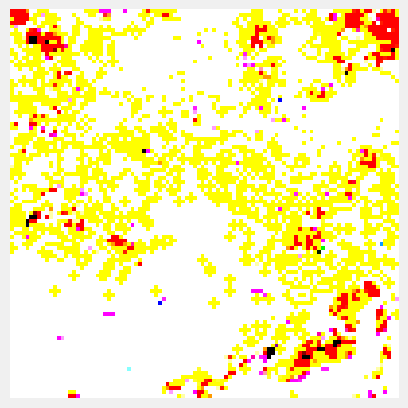

In [13]:
import lime
import lime.lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.segmentation import mark_boundaries
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np

model = load_model('/kaggle/working/resnet101_final_model.h5')

explainer = lime.lime_image.LimeImageExplainer()

img_path = '/kaggle/input/de-fungi/de_fungi/H4/H5_101a_1.jpg'
img = Image.open(img_path).resize((100, 100))
img = np.array(img)

if len(img.shape) == 2:
    img = np.stack((img,)*3, axis=-1)

img = preprocess_input(img)

def predict_fn(images):
    processed_images = np.array([preprocess_input(image) for image in images])
    return model.predict(processed_images)

explanation = explainer.explain_instance(img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.savefig("Cyst.png", dpi=300, bbox_inches='tight')

plt.show()

# H5

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

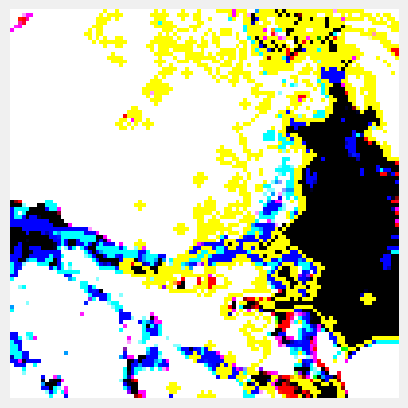

In [14]:
import lime
import lime.lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.segmentation import mark_boundaries
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np

model = load_model('/kaggle/working/resnet101_final_model.h5')

explainer = lime.lime_image.LimeImageExplainer()

img_path = '/kaggle/input/de-fungi/de_fungi/H5/H6_10a_2.jpg'
img = Image.open(img_path).resize((100, 100))
img = np.array(img)

if len(img.shape) == 2:
    img = np.stack((img,)*3, axis=-1)

img = preprocess_input(img)

def predict_fn(images):
    processed_images = np.array([preprocess_input(image) for image in images])
    return model.predict(processed_images)

explanation = explainer.explain_instance(img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.savefig("Cyst.png", dpi=300, bbox_inches='tight')

plt.show()

# SHAP

# H1

  0%|          | 0/7998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [03:55, 235.31s/it]              


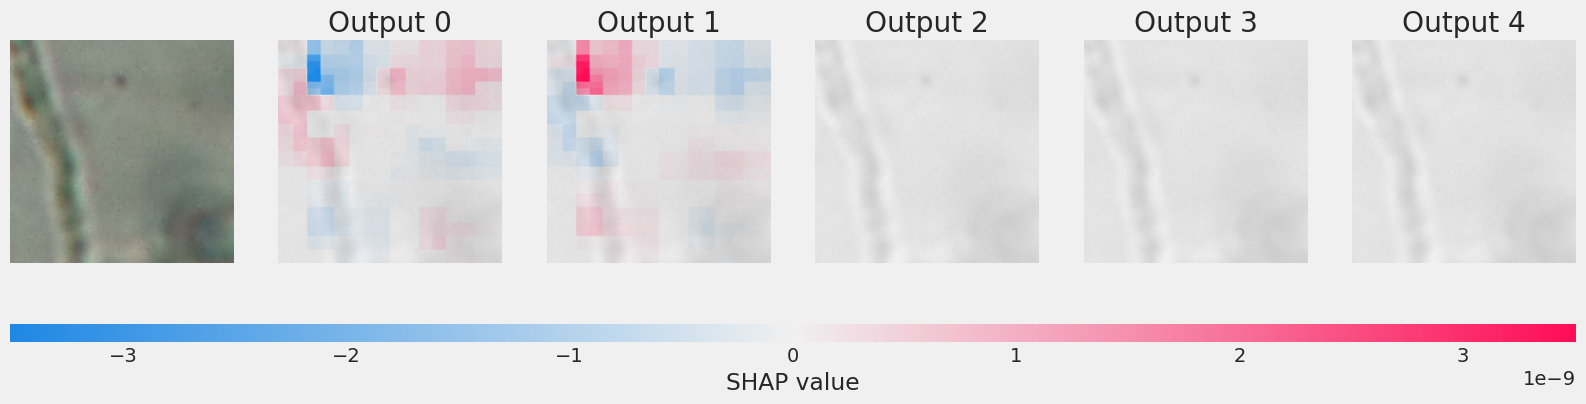

In [15]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model

dataset_dir = "/kaggle/input/de-fungi/de_fungi"

image_path = "/kaggle/input/de-fungi/de_fungi/H1/H1_10a_5.jpg"

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [100, 100])  
    image = tf.cast(image, tf.float32) / 255.0   
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('/kaggle/working/resnet101_final_model.h5')

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(100,100)", shape=(100, 100, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=8000, outputs=shap.Explanation.argsort.flip[:8])

shap.image_plot(shap_values_fine)

#fig = plt.figure(figsize=(10, 10))
#shap.image_plot(shap_values_fine, show=False)
#fig.savefig("shap_cyst.png", dpi=300, bbox_inches='tight')
plt.show()

# H2

  0%|          | 0/7998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [03:50, 230.73s/it]              


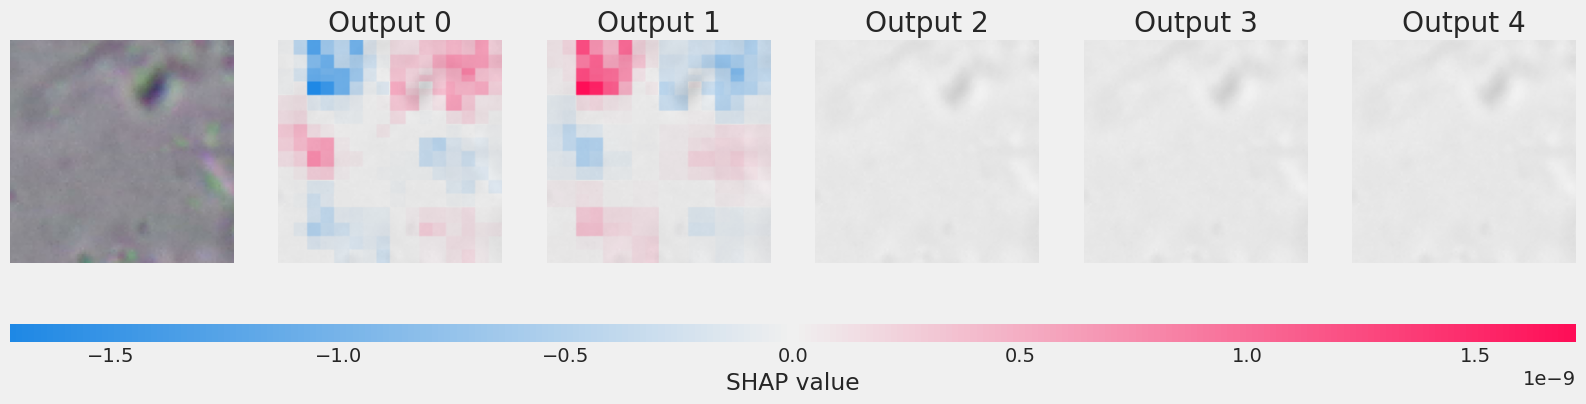

In [16]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model

dataset_dir = "/kaggle/input/de-fungi/de_fungi"

image_path = "/kaggle/input/de-fungi/de_fungi/H2/H2_11a_1.jpg"

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [100, 100])  
    image = tf.cast(image, tf.float32) / 255.0   
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('/kaggle/working/resnet101_final_model.h5')

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(100,100)", shape=(100, 100, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=8000, outputs=shap.Explanation.argsort.flip[:8])

shap.image_plot(shap_values_fine)

#fig = plt.figure(figsize=(10, 10))
#shap.image_plot(shap_values_fine, show=False)
plt.show()

# H3

  0%|          | 0/7998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [03:51, 231.43s/it]              


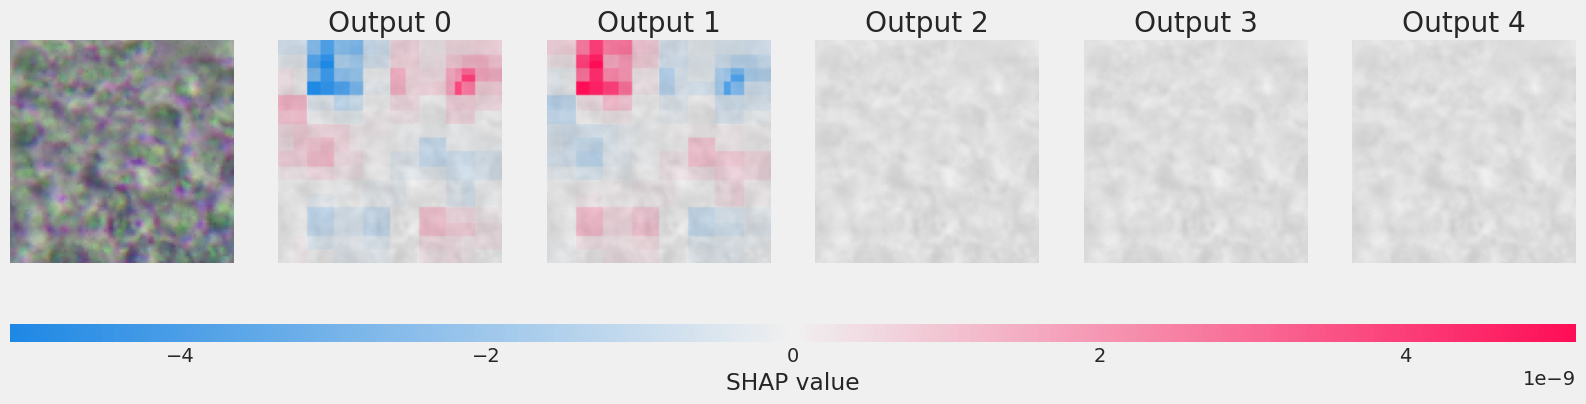

In [17]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model

dataset_dir = "/kaggle/input/de-fungi/de_fungi"

image_path = "/kaggle/input/de-fungi/de_fungi/H3/H3_10a_1.jpg"

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [100, 100])  
    image = tf.cast(image, tf.float32) / 255.0   
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('/kaggle/working/resnet101_final_model.h5')

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(100,100)", shape=(100, 100, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=8000, outputs=shap.Explanation.argsort.flip[:8])

shap.image_plot(shap_values_fine)

#fig = plt.figure(figsize=(10, 10))
#shap.image_plot(shap_values_fine, show=False)
plt.show()

# H4

  0%|          | 0/7998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [03:52, 232.09s/it]              


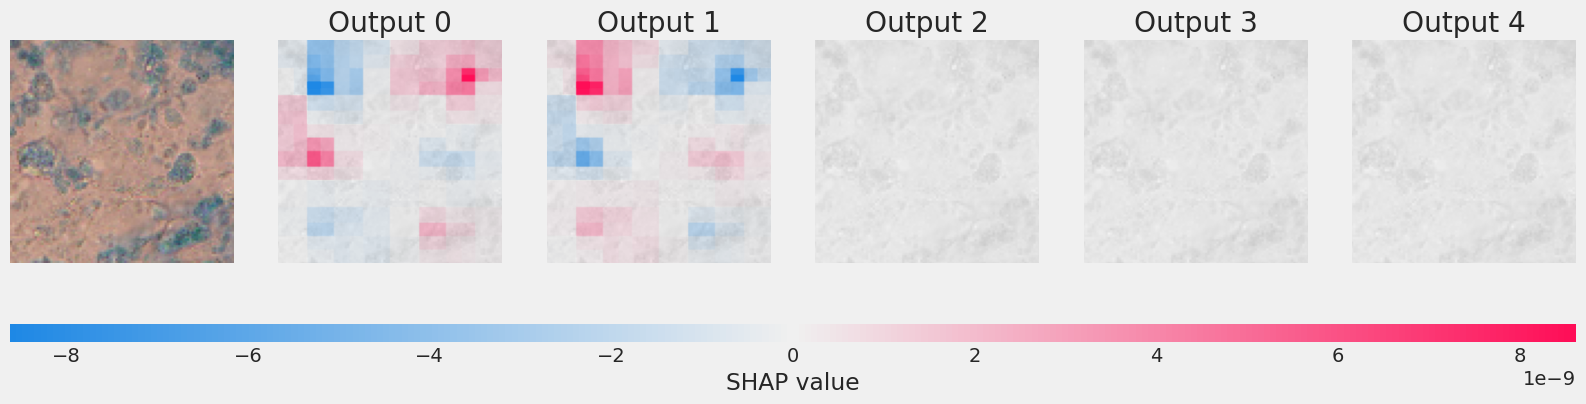

In [18]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model

dataset_dir = "/kaggle/input/de-fungi/de_fungi"

image_path = "/kaggle/input/de-fungi/de_fungi/H4/H5_101a_1.jpg"

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [100, 100])  
    image = tf.cast(image, tf.float32) / 255.0   
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('/kaggle/working/resnet101_final_model.h5')

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(100,100)", shape=(100, 100, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=8000, outputs=shap.Explanation.argsort.flip[:8])

shap.image_plot(shap_values_fine)

#fig = plt.figure(figsize=(10, 10))
#shap.image_plot(shap_values_fine, show=False)
plt.show()

# H5

  0%|          | 0/7998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [03:53, 233.25s/it]              


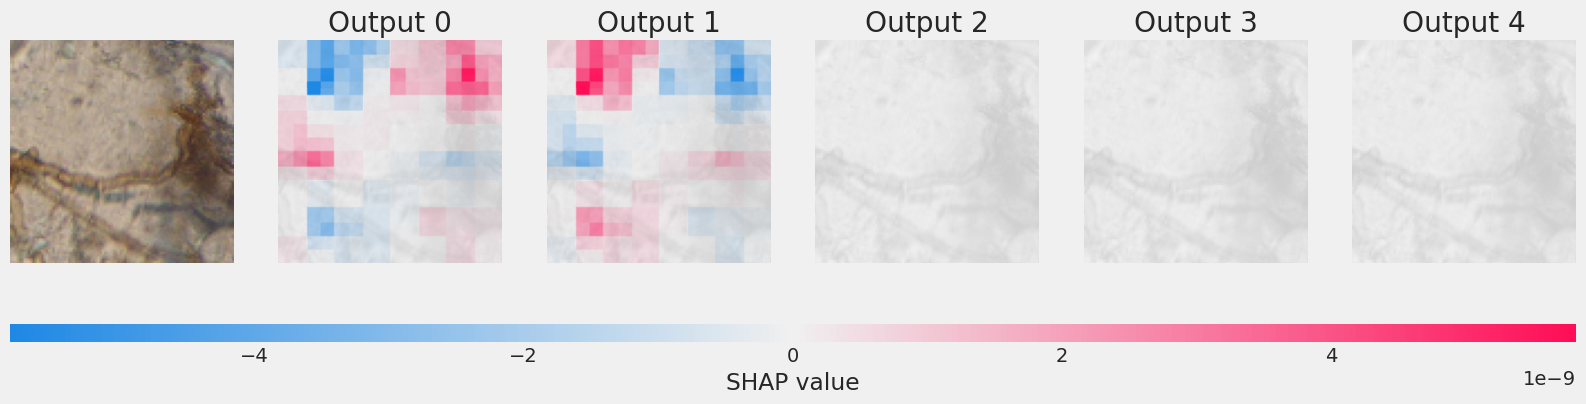

In [19]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model

dataset_dir = "/kaggle/input/de-fungi/de_fungi"

image_path = "/kaggle/input/de-fungi/de_fungi/H5/H6_10a_2.jpg"

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [100, 100])  
    image = tf.cast(image, tf.float32) / 255.0   
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('/kaggle/working/resnet101_final_model.h5')

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(100,100)", shape=(100, 100, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=8000, outputs=shap.Explanation.argsort.flip[:8])

shap.image_plot(shap_values_fine)

#fig = plt.figure(figsize=(10, 10))
#shap.image_plot(shap_values_fine, show=False)
plt.show()

# GRAD-CAM

# H1

179648224/179648224 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


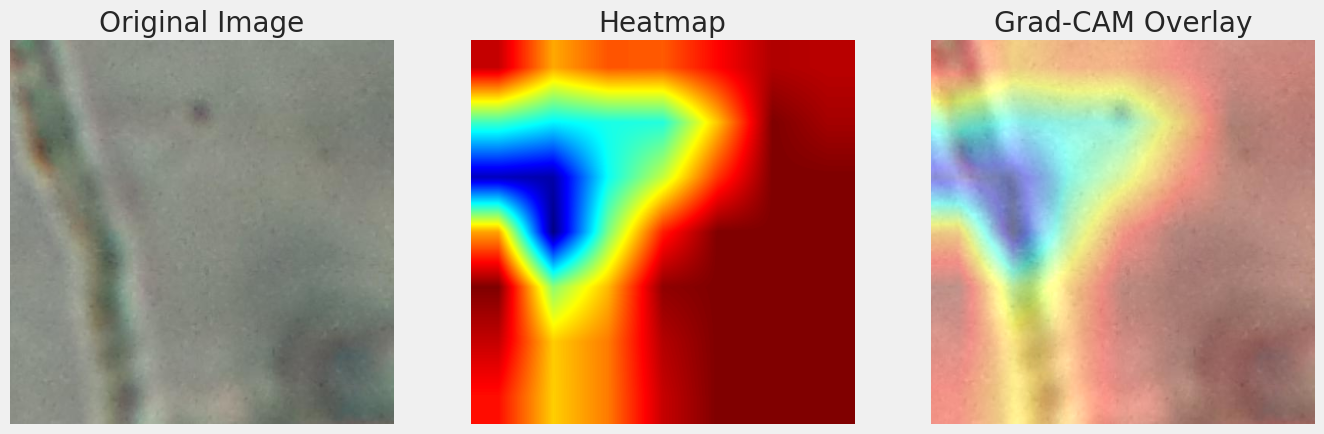

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

base_model = ResNet101(weights='imagenet')

def grad_cam(model, img_array, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    grad_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[0, predicted_class]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_output = conv_output[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array) 
    return img_array

img_path = "/kaggle/input/de-fungi/de_fungi/H1/H1_10a_5.jpg"
img_array = load_and_preprocess_image(img_path)

def display_grad_cam_alternative(heatmap, img_path, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    superimposed_img = np.float32(img) + alpha * np.float32(heatmap_colored)
    superimposed_img = np.uint8(np.clip(superimposed_img, 0, 255))
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Heatmap')
    plt.imshow(heatmap_colored)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Grad-CAM Overlay')
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

heatmap = grad_cam(base_model, img_array, 'conv5_block3_out', ['fc1000'])  # Last conv layer for ResNet101

display_grad_cam_alternative(heatmap, img_path)


# H2

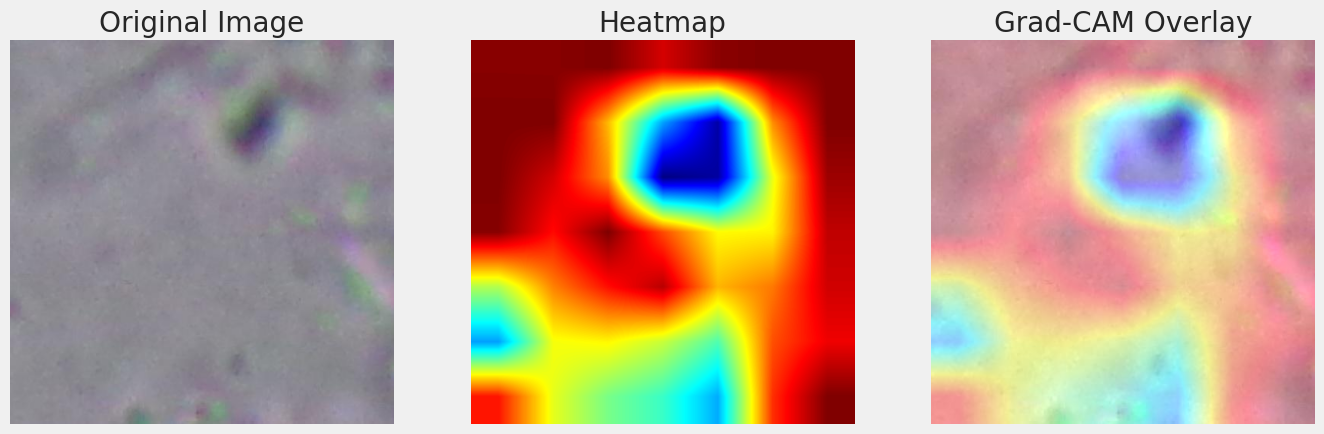

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

base_model = ResNet101(weights='imagenet')

def grad_cam(model, img_array, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    grad_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[0, predicted_class]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_output = conv_output[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  
    return img_array

img_path = "/kaggle/input/de-fungi/de_fungi/H2/H2_11a_1.jpg"
img_array = load_and_preprocess_image(img_path)

def display_grad_cam_alternative(heatmap, img_path, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    superimposed_img = np.float32(img) + alpha * np.float32(heatmap_colored)
    superimposed_img = np.uint8(np.clip(superimposed_img, 0, 255))
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Heatmap')
    plt.imshow(heatmap_colored)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Grad-CAM Overlay')
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

heatmap = grad_cam(base_model, img_array, 'conv5_block3_out', ['fc1000'])  # Last conv layer for ResNet101

display_grad_cam_alternative(heatmap, img_path)


# H3

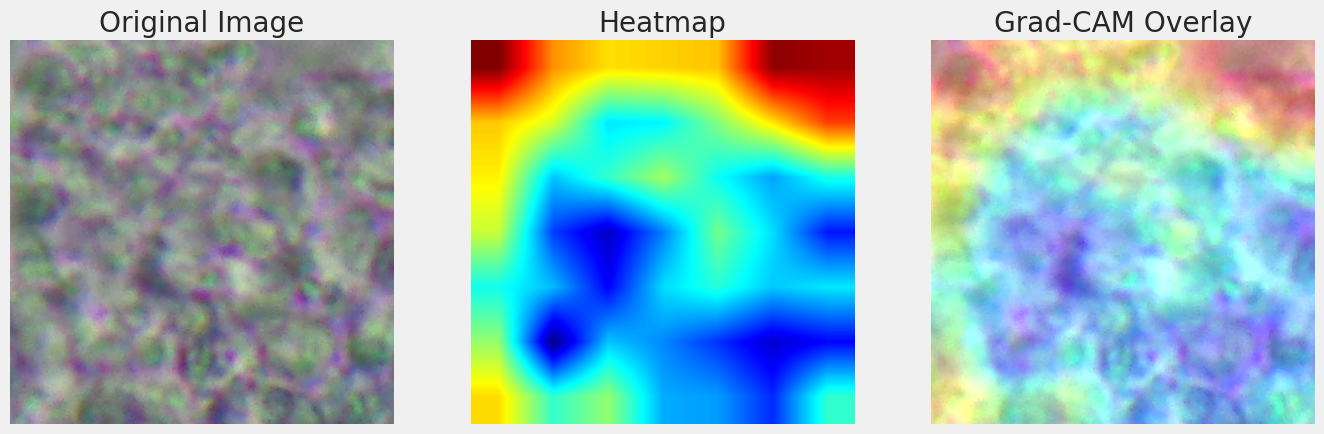

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

base_model = ResNet101(weights='imagenet')

def grad_cam(model, img_array, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    grad_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[0, predicted_class]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_output = conv_output[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocessing for ResNet
    return img_array

img_path = "/kaggle/input/de-fungi/de_fungi/H3/H3_10a_1.jpg"
img_array = load_and_preprocess_image(img_path)

def display_grad_cam_alternative(heatmap, img_path, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    superimposed_img = np.float32(img) + alpha * np.float32(heatmap_colored)
    superimposed_img = np.uint8(np.clip(superimposed_img, 0, 255))
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Heatmap')
    plt.imshow(heatmap_colored)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Grad-CAM Overlay')
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

heatmap = grad_cam(base_model, img_array, 'conv5_block3_out', ['fc1000'])  # Last conv layer for ResNet101

display_grad_cam_alternative(heatmap, img_path)


# GRAD-CAM++

# H1

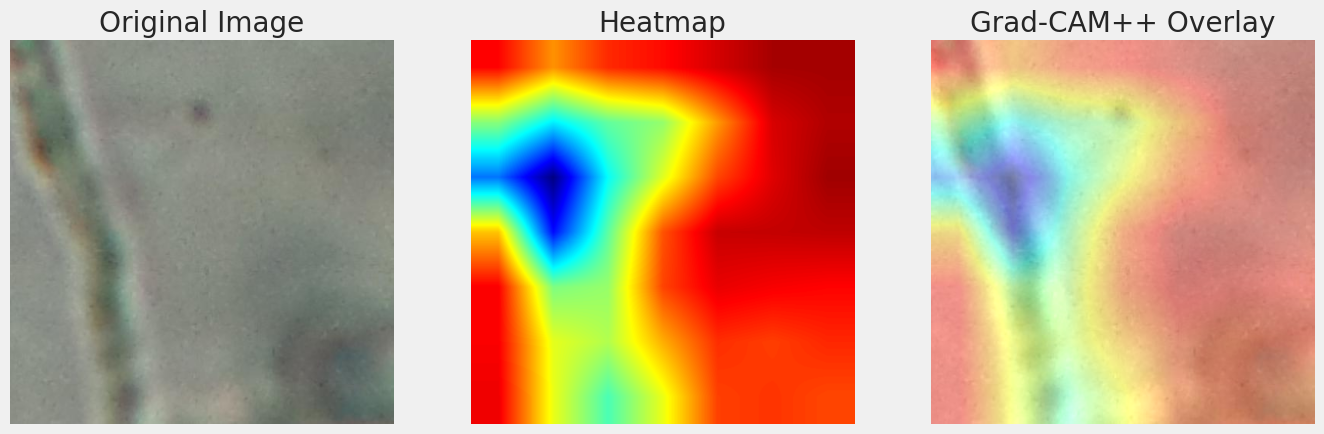

In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

base_model = ResNet101(weights='imagenet')

def grad_cam_plus_plus(model, img_array, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    grad_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[0, predicted_class]

    grads = tape.gradient(loss, conv_output)
    grads = grads[0]
    conv_output = conv_output[0]

    alpha_num = grads**2
    alpha_denom = 2 * grads**2 + tf.reduce_sum(conv_output * grads**3, axis=(0, 1))
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))  
    alphas = alpha_num / alpha_denom
    
    weights = tf.reduce_sum(alphas * tf.maximum(grads, 0.0), axis=(0, 1))
    
    grad_cam_pp = np.zeros(conv_output.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        grad_cam_pp += w * conv_output[:, :, i]
    
    heatmap = np.maximum(grad_cam_pp, 0)
    heatmap /= np.max(heatmap)  

    return heatmap

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  
    return img_array

img_path = "/kaggle/input/de-fungi/de_fungi/H1/H1_10a_5.jpg"
img_array = load_and_preprocess_image(img_path)

def display_grad_cam_alternative(heatmap, img_path, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    superimposed_img = np.float32(img) + alpha * np.float32(heatmap_colored)
    superimposed_img = np.uint8(np.clip(superimposed_img, 0, 255))
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Heatmap')
    plt.imshow(heatmap_colored)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Grad-CAM++ Overlay')
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

heatmap_pp = grad_cam_plus_plus(base_model, img_array, 'conv5_block3_out', ['fc1000'])  # Last conv layer for ResNet101

display_grad_cam_alternative(heatmap_pp, img_path)


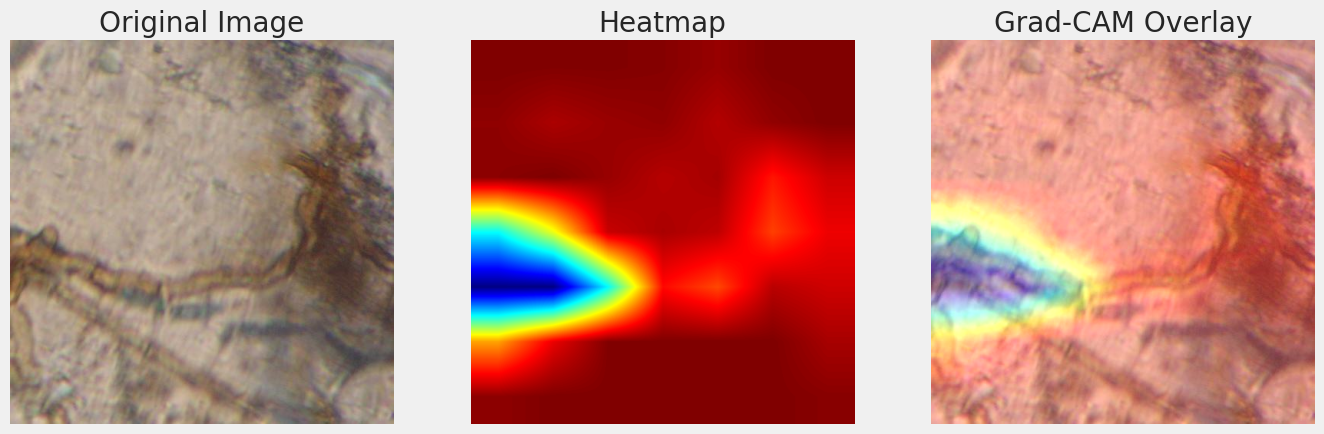

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

base_model = ResNet101(weights='imagenet')

def grad_cam(model, img_array, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    grad_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[0, predicted_class]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_output = conv_output[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

img_path = "/kaggle/input/de-fungi/de_fungi/H5/H6_10a_2.jpg"
img_array = load_and_preprocess_image(img_path)

def display_grad_cam_alternative(heatmap, img_path, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    superimposed_img = np.float32(img) + alpha * np.float32(heatmap_colored)
    superimposed_img = np.uint8(np.clip(superimposed_img, 0, 255))
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Heatmap')
    plt.imshow(heatmap_colored)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Grad-CAM Overlay')
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

heatmap = grad_cam(base_model, img_array, 'conv5_block3_out', ['fc1000'])  # Last conv layer for ResNet101

display_grad_cam_alternative(heatmap, img_path)


# H2

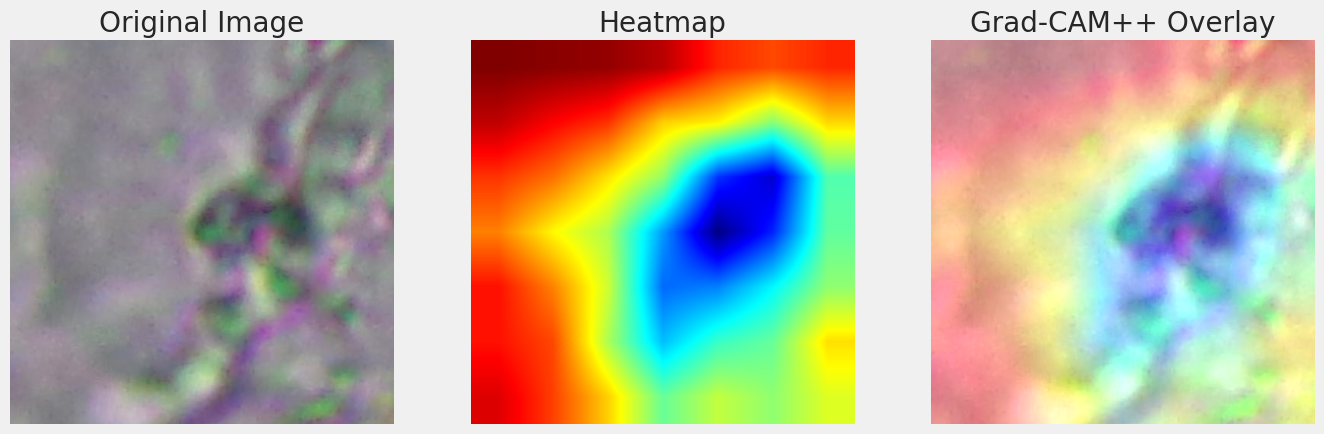

In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

base_model = ResNet101(weights='imagenet')

def grad_cam_plus_plus(model, img_array, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    grad_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[0, predicted_class]

    grads = tape.gradient(loss, conv_output)
    grads = grads[0]
    conv_output = conv_output[0]

    alpha_num = grads**2
    alpha_denom = 2 * grads**2 + tf.reduce_sum(conv_output * grads**3, axis=(0, 1))
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))  
    alphas = alpha_num / alpha_denom
    
    weights = tf.reduce_sum(alphas * tf.maximum(grads, 0.0), axis=(0, 1))
    
    grad_cam_pp = np.zeros(conv_output.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        grad_cam_pp += w * conv_output[:, :, i]
    
    heatmap = np.maximum(grad_cam_pp, 0)
    heatmap /= np.max(heatmap)  

    return heatmap

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  
    return img_array

img_path = "/kaggle/input/de-fungi/de_fungi/H2/H2_11a_10.jpg"
img_array = load_and_preprocess_image(img_path)

def display_grad_cam_alternative(heatmap, img_path, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    superimposed_img = np.float32(img) + alpha * np.float32(heatmap_colored)
    superimposed_img = np.uint8(np.clip(superimposed_img, 0, 255))
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Heatmap')
    plt.imshow(heatmap_colored)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Grad-CAM++ Overlay')
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

heatmap_pp = grad_cam_plus_plus(base_model, img_array, 'conv5_block3_out', ['fc1000'])  

display_grad_cam_alternative(heatmap_pp, img_path)


# H3

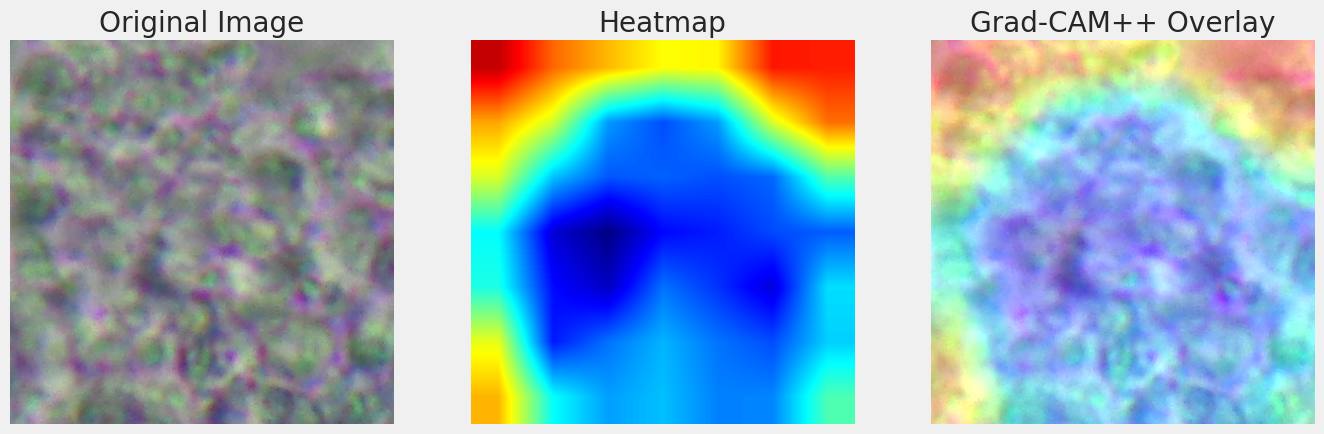

In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

base_model = ResNet101(weights='imagenet')

def grad_cam_plus_plus(model, img_array, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    grad_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[0, predicted_class]

    grads = tape.gradient(loss, conv_output)
    grads = grads[0]
    conv_output = conv_output[0]

    alpha_num = grads**2
    alpha_denom = 2 * grads**2 + tf.reduce_sum(conv_output * grads**3, axis=(0, 1))
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))  # Avoid division by zero
    alphas = alpha_num / alpha_denom
    
    weights = tf.reduce_sum(alphas * tf.maximum(grads, 0.0), axis=(0, 1))
    
    grad_cam_pp = np.zeros(conv_output.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        grad_cam_pp += w * conv_output[:, :, i]
    
    heatmap = np.maximum(grad_cam_pp, 0)
    heatmap /= np.max(heatmap)  

    return heatmap

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  
    return img_array

img_path = "/kaggle/input/de-fungi/de_fungi/H3/H3_10a_1.jpg"
img_array = load_and_preprocess_image(img_path)

def display_grad_cam_alternative(heatmap, img_path, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    superimposed_img = np.float32(img) + alpha * np.float32(heatmap_colored)
    superimposed_img = np.uint8(np.clip(superimposed_img, 0, 255))
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Heatmap')
    plt.imshow(heatmap_colored)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Grad-CAM++ Overlay')
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

heatmap_pp = grad_cam_plus_plus(base_model, img_array, 'conv5_block3_out', ['fc1000'])  

display_grad_cam_alternative(heatmap_pp, img_path)


# Saliency Maps

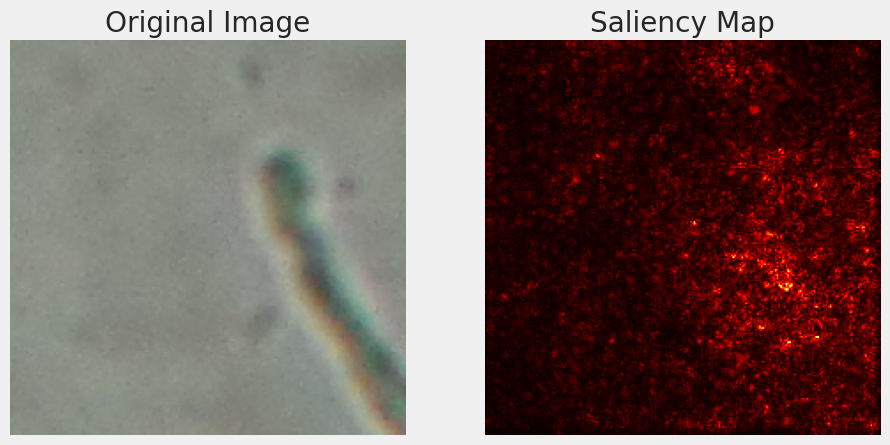

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing import image

model = ResNet101(weights='imagenet')

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)
    return img_array

def compute_saliency_map(img_array):
    img_tensor = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        predicted_class = tf.argmax(preds[0])
        loss = preds[0, predicted_class]

    grads = tape.gradient(loss, img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()
    return saliency

def display_saliency_map(saliency, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(saliency[0], cmap='hot')
    plt.axis('off')
    plt.title('Saliency Map')
    plt.show()

img_path = '/kaggle/input/de-fungi/de_fungi/H1/H1_10a_1.jpg' 
img_array = load_and_preprocess_image(img_path)
saliency = compute_saliency_map(img_array)
display_saliency_map(saliency, img_path)


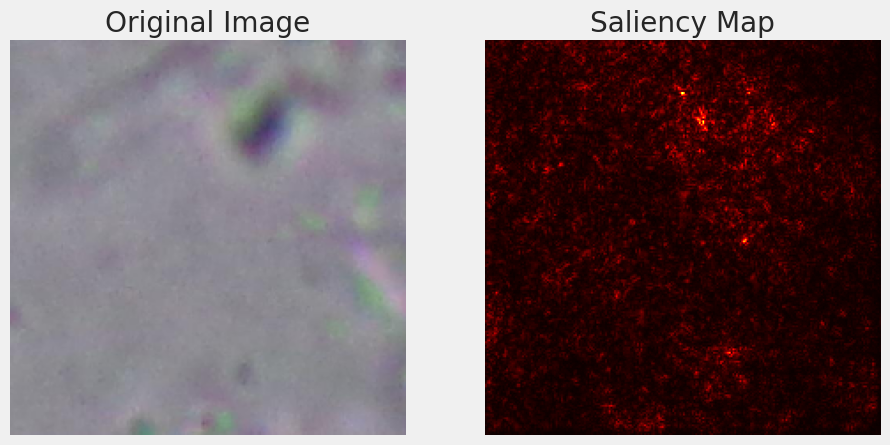

In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing import image

model = ResNet101(weights='imagenet')

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)
    return img_array

def compute_saliency_map(img_array):
    # Convert image array to tensor
    img_tensor = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        predicted_class = tf.argmax(preds[0])
        loss = preds[0, predicted_class]

    grads = tape.gradient(loss, img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()
    return saliency

def display_saliency_map(saliency, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(saliency[0], cmap='hot')
    plt.axis('off')
    plt.title('Saliency Map')
    plt.show()

img_path = '/kaggle/input/de-fungi/de_fungi/H2/H2_11a_1.jpg'  
img_array = load_and_preprocess_image(img_path)
saliency = compute_saliency_map(img_array)
display_saliency_map(saliency, img_path)


# Activation Maximization

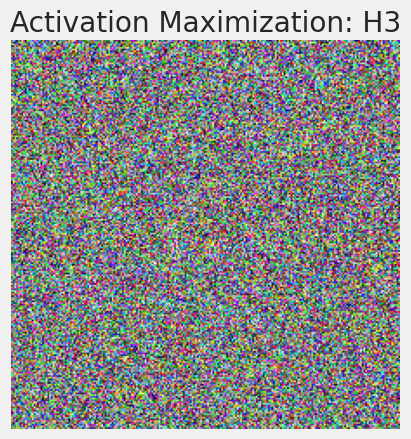

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.applications.resnet import ResNet101, preprocess_input, decode_predictions

model = ResNet101(weights='imagenet')

target_class_index = 2  
target_class_name = 'H3'  

def create_random_image():
    random_image = np.random.rand(1, 224, 224, 3) * 255
    return random_image.astype(np.float32)

def activation_maximization(model, target_class_index, iterations=100, step=0.1):
    input_image = create_random_image()
    input_tensor = tf.Variable(input_image, dtype=tf.float32)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            preds = model(input_tensor)
            loss = -preds[0][target_class_index]  

        grads = tape.gradient(loss, input_tensor)
        input_tensor.assign_add(step * tf.sign(grads))  
        input_tensor.assign(tf.clip_by_value(input_tensor, 0, 255))  

    return input_tensor.numpy()

def display_image(image):
    plt.imshow(image[0].astype(np.uint8))
    plt.title(f'Activation Maximization: {target_class_name}')
    plt.axis('off')
    plt.show()

maximized_image = activation_maximization(model, target_class_index)
display_image(maximized_image)


# SmoothGrad

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
(1, 224, 224, 3)


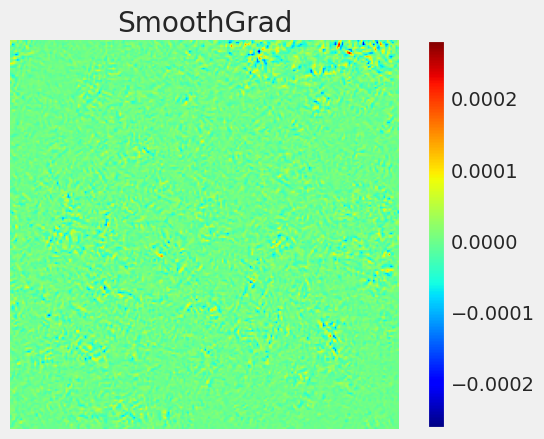

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.preprocessing import image

model = ResNet101(weights='imagenet')

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array = preprocess_input(img_array)  
    return img_array

def smooth_grad(img_array, model, class_index, n_samples=50, noise=0.1):
    gradients = np.zeros_like(img_array)

    for _ in range(n_samples):
        noisy_img = img_array + noise * np.random.normal(size=img_array.shape)
        noisy_img = np.clip(noisy_img, -127.5, 127.5)  
        
        noisy_img_tensor = tf.convert_to_tensor(noisy_img, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(noisy_img_tensor)
            preds = model(noisy_img_tensor)
            loss = preds[0][class_index]

        grads = tape.gradient(loss, noisy_img_tensor)
        gradients += grads.numpy()  

    return gradients / n_samples

img_path = "/kaggle/input/de-fungi/de_fungi/H3/H3_10a_1.jpg"
img_array = load_and_preprocess_image(img_path)

preds = model.predict(img_array)
class_index = np.argmax(preds)

smooth_grad_map = smooth_grad(img_array, model, class_index)

print(smooth_grad_map.shape)  

if len(smooth_grad_map.shape) == 4:
    smooth_grad_map = smooth_grad_map[0]  

plt.imshow(np.mean(smooth_grad_map, axis=-1), cmap='jet')  
plt.colorbar()
plt.title('SmoothGrad')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
(1, 224, 224, 3)


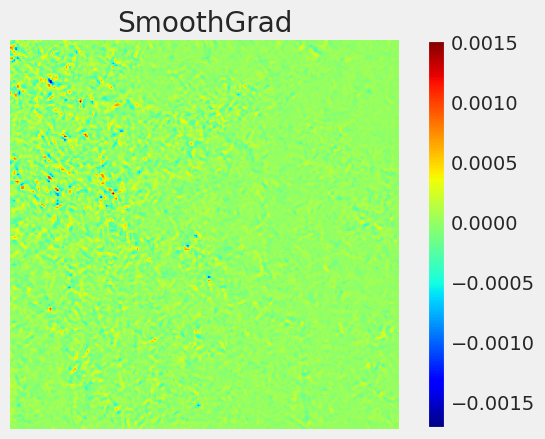

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.preprocessing import image

model = ResNet101(weights='imagenet')

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)  
    return img_array

def smooth_grad(img_array, model, class_index, n_samples=50, noise=0.1):
    gradients = np.zeros_like(img_array)

    for _ in range(n_samples):
        noisy_img = img_array + noise * np.random.normal(size=img_array.shape)
        noisy_img = np.clip(noisy_img, -127.5, 127.5)  
        
        noisy_img_tensor = tf.convert_to_tensor(noisy_img, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(noisy_img_tensor)
            preds = model(noisy_img_tensor)
            loss = preds[0][class_index]

        grads = tape.gradient(loss, noisy_img_tensor)
        gradients += grads.numpy()  

    return gradients / n_samples

img_path = "/kaggle/input/de-fungi/de_fungi/H1/H1_10a_5.jpg"
img_array = load_and_preprocess_image(img_path)

preds = model.predict(img_array)
class_index = np.argmax(preds)

smooth_grad_map = smooth_grad(img_array, model, class_index)

print(smooth_grad_map.shape)  

if len(smooth_grad_map.shape) == 4:
    smooth_grad_map = smooth_grad_map[0] 

plt.imshow(np.mean(smooth_grad_map, axis=-1), cmap='jet') 
plt.colorbar()
plt.title('SmoothGrad')
plt.axis('off')
plt.show()
